Example

In [1]:
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer 
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel 
from pyspark.ml import Pipeline, PipelineModel 
from pyspark.mllib.evaluation import MulticlassMetrics 
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder 
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import SparkSession
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
spark = (SparkSession.builder
         .master('local')
         .appName('Demo full pipeline')
         .getOrCreate())

In [3]:
#--------------------------------------------------------------
# Chargement du dataset
#--------------------------------------------------------------
rawdata = spark.read.options(header='True', inferSchema='True').format("csv").load("logreg-dataset.csv")

In [4]:
## printSchema
rawdata.printSchema()

root
 |-- Country: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Repeat_Visitor: integer (nullable = true)
 |-- Platform: string (nullable = true)
 |-- Web_pages_viewed: integer (nullable = true)
 |-- Status: integer (nullable = true)



In [5]:
rawdata.show(5) # What is Web_pages_viewed? id?

+---------+---+--------------+--------+----------------+------+
|  Country|Age|Repeat_Visitor|Platform|Web_pages_viewed|Status|
+---------+---+--------------+--------+----------------+------+
|    India| 41|             1|   Yahoo|              21|     1|
|   Brazil| 28|             1|   Yahoo|               5|     0|
|   Brazil| 40|             0|  Google|               3|     0|
|Indonesia| 31|             1|    Bing|              15|     1|
| Malaysia| 32|             0|  Google|              15|     1|
+---------+---+--------------+--------+----------------+------+
only showing top 5 rows



In [6]:
#--------------------------------------------------------------
# EDA
#--------------------------------------------------------------

In [7]:
rawdata.describe().show()

+-------+--------+-----------------+-----------------+--------+-----------------+------------------+
|summary| Country|              Age|   Repeat_Visitor|Platform| Web_pages_viewed|            Status|
+-------+--------+-----------------+-----------------+--------+-----------------+------------------+
|  count|   20000|            20000|            20000|   20000|            20000|             20000|
|   mean|    null|         28.53955|           0.5029|    null|           9.5533|               0.5|
| stddev|    null|7.888912950773227|0.500004090187782|    null|6.073903499824976|0.5000125004687693|
|    min|  Brazil|               17|                0|    Bing|                1|                 0|
|    max|Malaysia|              111|                1|   Yahoo|               29|                 1|
+-------+--------+-----------------+-----------------+--------+-----------------+------------------+



In [8]:
rawdata.groupBy("Country").count().show()

+---------+-----+
|  Country|count|
+---------+-----+
| Malaysia| 1218|
|    India| 4018|
|Indonesia|12178|
|   Brazil| 2586|
+---------+-----+



In [9]:
rawdata.groupBy("Platform").count().show()

+--------+-----+
|Platform|count|
+--------+-----+
|   Yahoo| 9859|
|    Bing| 4360|
|  Google| 5781|
+--------+-----+



In [10]:
rawdata.groupBy("Status").count().show()

+------+-----+
|Status|count|
+------+-----+
|     1|10000|
|     0|10000|
+------+-----+



In [11]:
rawdata.groupBy("Country").mean().show()

+---------+------------------+-------------------+---------------------+--------------------+
|  Country|          avg(Age)|avg(Repeat_Visitor)|avg(Web_pages_viewed)|         avg(Status)|
+---------+------------------+-------------------+---------------------+--------------------+
| Malaysia|27.792282430213465| 0.5730706075533661|   11.192118226600986|  0.6568144499178982|
|    India|27.976854156296664| 0.5433051269288203|   10.727227476356397|  0.6212045793927327|
|Indonesia| 28.43159796354081| 0.5207751683363442|    9.985711939563148|  0.5422893742814913|
|   Brazil|30.274168600154677|  0.322892498066512|    4.921113689095128|0.038669760247486466|
+---------+------------------+-------------------+---------------------+--------------------+



In [12]:
rawdata.groupBy("Platform").mean().show()

+--------+------------------+-------------------+---------------------+------------------+
|Platform|          avg(Age)|avg(Repeat_Visitor)|avg(Web_pages_viewed)|       avg(Status)|
+--------+------------------+-------------------+---------------------+------------------+
|   Yahoo|28.569226087838523| 0.5094837204584644|    9.599655137437875|0.5071508266558474|
|    Bing| 28.68394495412844| 0.4720183486238532|    9.114908256880733|0.4559633027522936|
|  Google|28.380038055699707| 0.5149628092025601|    9.804878048780488|0.5210171250648676|
+--------+------------------+-------------------+---------------------+------------------+



In [13]:
rawdata.groupBy("Status").mean().show()

+------+--------+-------------------+---------------------+-----------+
|Status|avg(Age)|avg(Repeat_Visitor)|avg(Web_pages_viewed)|avg(Status)|
+------+--------+-------------------+---------------------+-----------+
|     1| 26.5435|             0.7019|              14.5617|        1.0|
|     0| 30.5356|             0.3039|               4.5449|        0.0|
+------+--------+-------------------+---------------------+-----------+



In [14]:
## Analyse visuelle
pandasDF = rawdata.toPandas()
pandasDF.head(100)

,Country,Age,Repeat_Visitor,Platform,Web_pages_viewed,Status
0,India,41,1,Yahoo,21,1
1,Brazil,28,1,Yahoo,5,0
2,Brazil,40,0,Google,3,0
3,Indonesia,31,1,Bing,15,1
4,Malaysia,32,0,Google,15,1
...,...,...,...,...,...,...
95,Indonesia,21,0,Google,3,0
96,India,51,1,Yahoo,4,0
97,India,26,1,Yahoo,11,1
98,India,33,1,Bing,4,0


<Axes: xlabel='Platform', ylabel='count'>

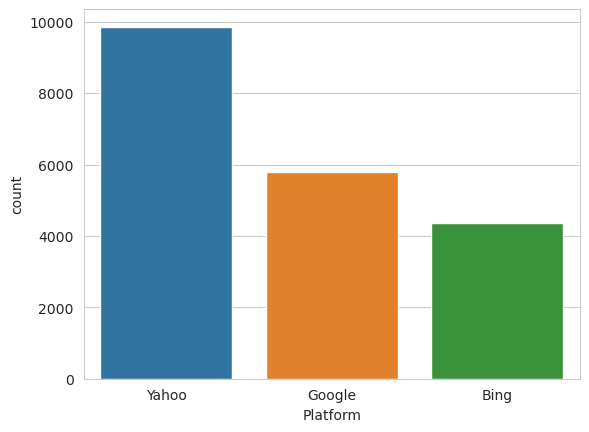

In [15]:
## Platforme
sns.set_style('whitegrid')
sns.countplot(x='Platform',data=pandasDF)

<Axes: xlabel='Country', ylabel='count'>

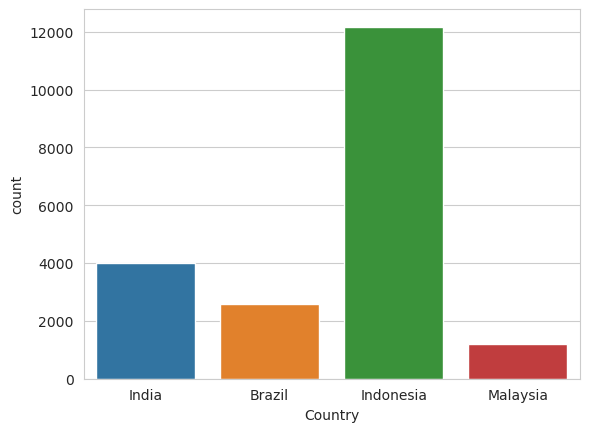

In [16]:
## Pays
sns.set_style('whitegrid')
sns.countplot(x='Country',data=pandasDF)

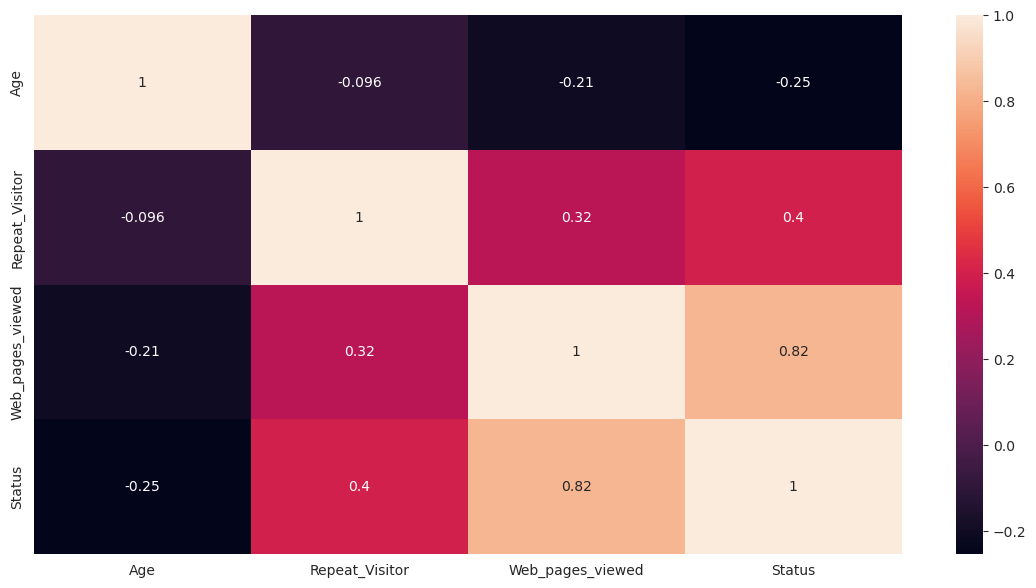

In [17]:
## Corrélations
plt.figure(figsize=(14,7))
cor = pandasDF.corr()
sns.heatmap(cor, annot=True)
plt.show()

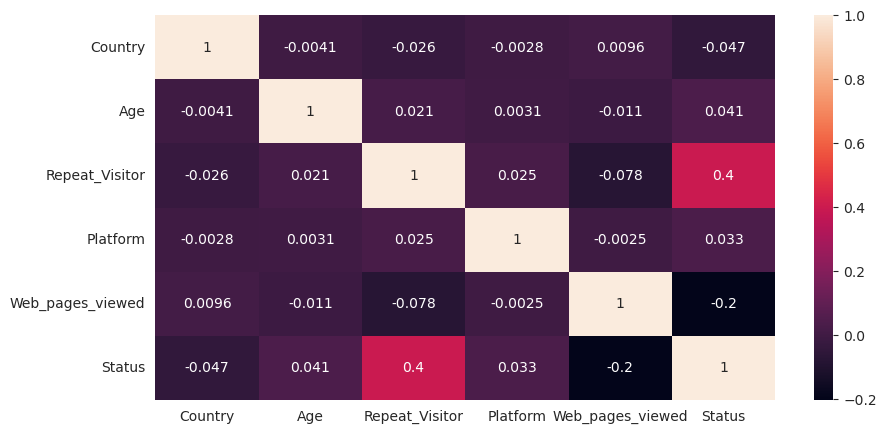

In [18]:
## Corrélations avec variables catégorielles
corrDF = pandasDF.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
corrDF
plt.figure(figsize=(10,5))
sns.heatmap(corrDF, annot=True)
plt.show()

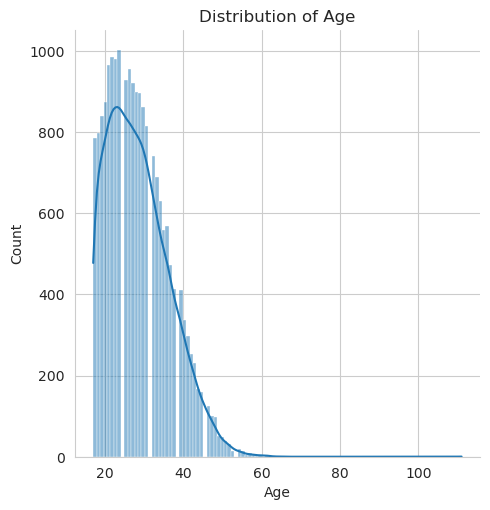

In [19]:
## Distributions
sns.displot(x='Age',data=pandasDF,kde=True)
plt.title('Distribution of Age')
plt.show()

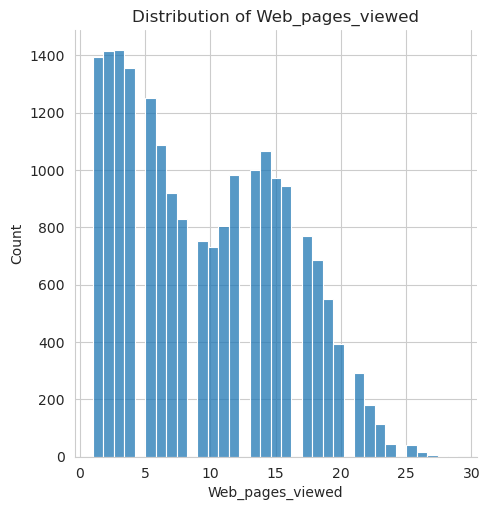

In [20]:
sns.displot(x='Web_pages_viewed',data=pandasDF,kde=False)
plt.title('Distribution of Web_pages_viewed')
plt.show()

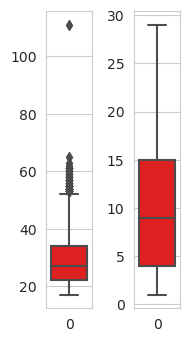

In [21]:
## Outliers
numericDF = pandasDF[['Age', 'Web_pages_viewed']].copy()
l = numericDF.columns.values
number_of_columns=2
number_of_rows = round(len(l)-1/number_of_columns)
plt.figure(figsize=(number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows+1,number_of_columns,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(data=numericDF[l[i]],color="red",orient="v")
    plt.tight_layout()

In [24]:
number_of_rows

2

In [25]:
#--------------------------------------------------------------
# Etape 1 du pipeline: indexing 
#--------------------------------------------------------------
searchEngineIndexer = StringIndexer(inputCol="Platform", outputCol="Search_Engine_Num")

In [27]:
#--------------------------------------------------------------
# Etape 2 du pipeline: one hot encoder
#--------------------------------------------------------------
searchEngineEncoder = OneHotEncoder(inputCols=["Search_Engine_Num"], outputCols=["Search_Engine_Vector"])

In [28]:
#--------------------------------------------------------------
# Etape 3: indexing
#--------------------------------------------------------------
countryIndexer = StringIndexer(inputCol="Country", outputCol="Country_Num")

In [29]:
#--------------------------------------------------------------
# Etap 4: one hot encoder
#--------------------------------------------------------------
countryEncoder = OneHotEncoder(inputCols=["Country_Num"], outputCols=["Country_Vector"])

In [30]:
#--------------------------------------------------------------
# Etape 5: assembler
#--------------------------------------------------------------
dfAssembler = VectorAssembler(inputCols=["Search_Engine_Vector", 
                                         "Country_Vector", 
                                         "Age",
                                         "Repeat_Visitor",
                                         "Web_pages_viewed"], outputCol="features")

In [32]:
#--------------------------------------------------------------
# Etape 6: choix de l'algorithme
#--------------------------------------------------------------
logreg = LogisticRegression(labelCol="Status")

In [34]:
# Pipeline
pipeline = Pipeline(stages=[searchEngineIndexer,
                            searchEngineEncoder,
                            countryIndexer,
                            countryEncoder,
                            dfAssembler,
                            logreg])

In [35]:
#--------------------------------------------------------------
# Les données: entraînement + test 
#--------------------------------------------------------------
trainDf, testDf = rawdata.randomSplit([0.75, 0.25])

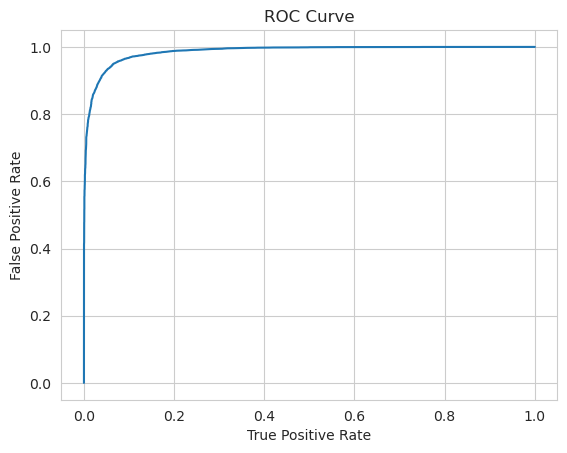

Training set areaUnderROC: 0.9861448944065666


In [36]:
# Résultats
model = pipeline.fit(trainDf)

trainingSummary = model.stages[-1].summary
roc = trainingSummary.roc.toPandas()

plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [37]:
#--------------------------------------------------------------
# Avec les données de test
#--------------------------------------------------------------
results = model.transform(testDf)

results.select("Status","prediction","rawPrediction","probability").show(40, truncate=False)

predictionAndLabels= results.rdd.map(lambda row: (float(row.Status), row.prediction))

# Récupération des métriques
metrics = MulticlassMetrics(predictionAndLabels)

# Matrice de confusion
print("Confusion matrix: %s" % metrics.confusionMatrix().toArray())
print("True negative: %s" % metrics.confusionMatrix().toArray()[0,0])
print("False positive: %s" % metrics.confusionMatrix().toArray()[0,1])
print("False negative: %s" % metrics.confusionMatrix().toArray()[1,0])
print("True positive: %s" % metrics.confusionMatrix().toArray()[1,1])
print("Accuracy = %s" % metrics.accuracy)

+------+----------+------------------------------------------+------------------------------------------+
|Status|prediction|rawPrediction                             |probability                               |
+------+----------+------------------------------------------+------------------------------------------+
|0     |0.0       |[7.174095279959516,-7.174095279959516]    |[0.9992344079984501,7.655920015499085E-4] |
|0     |0.0       |[4.8997393834662155,-4.8997393834662155]  |[0.9926065462910854,0.0073934537089146435]|
|0     |0.0       |[9.326904641962074,-9.326904641962074]    |[0.9999110106301533,8.898936984669259E-5] |
|0     |0.0       |[9.326904641962074,-9.326904641962074]    |[0.9999110106301533,8.898936984669259E-5] |
|0     |0.0       |[9.326904641962074,-9.326904641962074]    |[0.9999110106301533,8.898936984669259E-5] |
|0     |0.0       |[8.568786009797641,-8.568786009797641]    |[0.9998100929725662,1.8990702743382215E-4]|
|0     |0.0       |[7.0525487454687745,-7.0525

In [38]:
#--------------------------------------------------------------
# BinaryClassificationEvaluator
#--------------------------------------------------------------
evaluator = BinaryClassificationEvaluator(labelCol="Status",rawPredictionCol="rawPrediction", metricName="areaUnderPR")
						
print("Model accuracy : %s " % evaluator.evaluate(results))

Model accuracy : 0.9849853010404322 


In [39]:
#--------------------------------------------------------------
# Cross validation
#--------------------------------------------------------------
cv = CrossValidator(estimator=pipeline, evaluator=evaluator, numFolds=5, collectSubModels=True)
					
params = ParamGridBuilder().addGrid(logreg.maxIter,[1000]).addGrid(logreg.regParam, [ 0.5, 0.05, 0.1,]).build()
						
cv.setEstimatorParamMaps(params)
cvmodel = cv.fit(trainDf)

bestModel = cvmodel.bestModel
print("Coefficients: \n %s" % bestModel.stages[5].coefficients)
print("Best regParam: %s" % bestModel.stages[5].getRegParam())
bestModel.stages[5].extractParamMap()

Coefficients: 
 [0.054067737672008766,0.06629934662618425,0.09937325264068232,0.28610597468122617,-1.3182731043770028,-0.03681003328415644,0.9276327065718224,0.277794642331133]
Best regParam: 0.05


{Param(parent='LogisticRegression_9532b90a5985', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2,
 Param(parent='LogisticRegression_9532b90a5985', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0,
 Param(parent='LogisticRegression_9532b90a5985', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial'): 'auto',
 Param(parent='LogisticRegression_9532b90a5985', name='featuresCol', doc='features column name.'): 'features',
 Param(parent='LogisticRegression_9532b90a5985', name='fitIntercept', doc='whether to fit an intercept term.'): True,
 Param(parent='LogisticRegression_9532b90a5985', name='labelCol', doc='label column name.'): 'Status',
 Param(parent='LogisticRegression_9532b90a5985', name='maxBlockSizeInMB', doc='maximum memory in MB for 

In [40]:
#--------------------------------------------------------------
# Prédiction
#--------------------------------------------------------------
from pyspark.sql import Row
toPredict = spark.createDataFrame([Row(Country='Indonesia', Age=54, Repeat_Visitor=0, Platform='Yahoo', Web_pages_viewed=5),\
                                   Row(Country='Brazil', Age=35, Repeat_Visitor=1, Platform='Bing', Web_pages_viewed=15),\
                                   Row(Country='Brazil', Age=35, Repeat_Visitor=0, Platform='Google', Web_pages_viewed=5),\
                                   Row(Country='India', Age=22, Repeat_Visitor=0, Platform='Yahoo', Web_pages_viewed=10)])
predictions=bestModel.transform(toPredict)
predictions.select("prediction").show()

+----------+
|prediction|
+----------+
|       0.0|
|       1.0|
|       0.0|
|       1.0|
+----------+

